In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,text,inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
database_path = Path("../Resources/hawaii.sqlite")
# reflect the tables
from sqlalchemy.ext.declarative import declarative_base
Basemodel = declarative_base()
conn = engine.connect()

In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

<Axes: xlabel='Date', ylabel='Inches'>

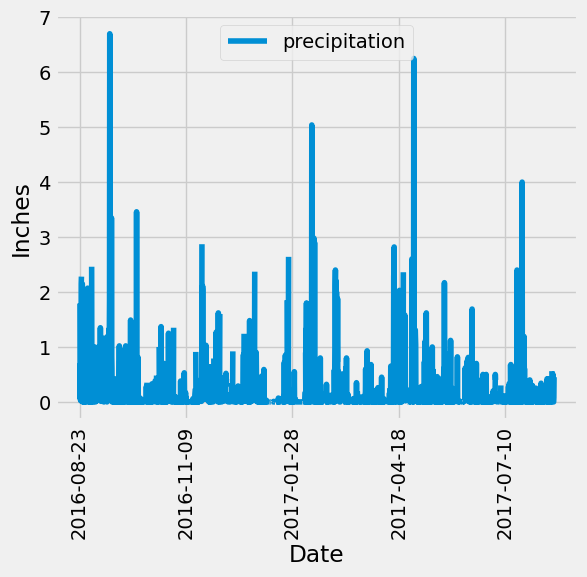

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
first_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_12 = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_12, columns=['date','precipitation'])
df.set_index('date',  inplace=True)

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90, xlabel = 'Date', ylabel='Inches', figsize=(6,5))

In [14]:
from scipy import stats
from numpy import mean

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).first()[0]
station_count

9

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()
print(min_temp,max_temp,avg_temp)

(54.0,) (85.0,) (71.66378066378067,)


Text(0.5, 0, 'Temperature')

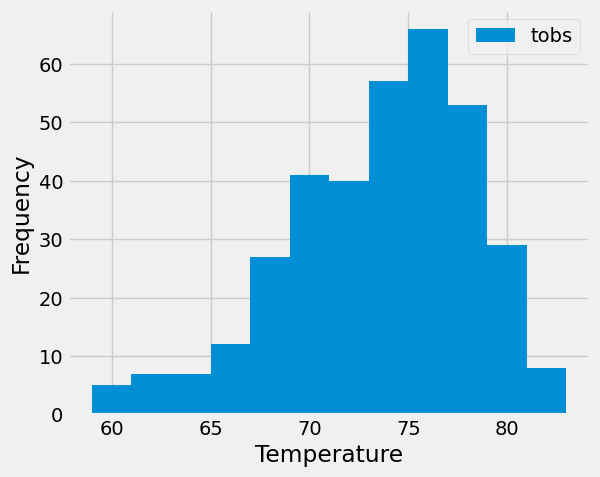

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= first_date).all()
station_df = pd.DataFrame(data, columns=['tobs'])

station_df.plot.hist(bins=12, figsize=(6, 5))
plt.xlabel('Temperature')

# Close Session

In [20]:
# Close Session
session.close()

In [31]:
from flask import Flask, jsonify
import datetime as dt


In [46]:
app = Flask(__name__)

In [47]:
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/start<br/>"
        f"/api/v1.0/start/end"
    )


In [48]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all precipitation and date"""
    # Query all precipitation and date
    results = session.query(Measurement.date,Measurement.prcp).all()

    session.close()

    # Convert list of tuples into dictionary
    all_precepitation=[]
    for date,prcp in results:
        precipitation_dict = {}
        precipitation_dict[date] = prcp
        all_precepitation.append(precipitation_dict)

    return jsonify(all_precepitation)


In [35]:
@app.route("/api/v1.0/stations")
def stations():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all stations"""
    # Query all stations
    results = session.query(Station.id,Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
    session.close()
    all_station=[]
    for id,station,name,latitude,longitude,elevation in results:
        station_dict={}
        station_dict['Id']=id
        station_dict['station']=station
        station_dict['name']=name
        station_dict['latitude']=latitude
        station_dict['longitude']=longitude
        station_dict['elevation']=elevation
        all_station.append(station_dict)
    return jsonify(all_station)

In [75]:
 @app.route("/api/v1.0/tobs")

     # Create our session (link) from Python to the DB
    session = Session(engine)
     # Query the dates and temperature observations of the most-active station for the previous year of data
last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()
measurement_tobs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                filter(Measurement.date>= last_12_months).statement
measurement_tobs= pd.DataFrame(last_12, columns=[ 'Precipitation','tobs'])

measurement_tobs
# Close Session
session.close()

,Precipitation,tobs
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
...,...,...
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [70]:
# Close Session
session.close()